In [1]:
from __init__ import *
from keras.models import load_model
% matplotlib inline

Using TensorFlow backend.


In [2]:
key = 'artificial'
mindate = '2017-01-12'
files = [f for f in os.listdir('results') if (key in f) and ('.pkl' in f)]
read_tables = []
for f in files:
    try:
        df = pd.read_pickle('results/' + f)
        df = df[df['dt'] > pd.Timestamp(mindate)]
        df['epochs'] = df['loss'].apply(lambda x: len(x))
        df = df[df['epochs'] > 5]
        if df.shape[0] == 0:
            continue
        if 'objective' not in df.columns:
            df['objective'] = 'regr' if ('regr' in f) else 'class'
        if 'returns' not in df.columns:
            df['returns'] = ('ret' in f)
        elif 'both' in f:
            df = df[df['returns']] ###### screwed up classification loss in 'both'
        if 'full_shift' not in df.columns:
            df['full_shift'] = True
        df['NeX'] = ('NeX' in f)
        if 'batch_size' not in df.columns:
            df['batch_size'] = 64
        if 'channels' not in df.columns:
            if 'filters' in df.columns:
                df['channels'] = df['filters']
            else:
                df['channels'] = 1
        else:
            df.loc[np.isnan(df['channels']), 'channels'] = 1
        if 'model' in df.columns:
            pass
        elif ('benchmark' in f) or ('lr' in f):
            df['model'] = 'lr'
        elif 'cnn' in f:
            df['model'] = 'cnn'
        elif 'gru' in f:
            df['model'] = 'gru'
        elif 'lstm' in f:
            df['model'] = 'lstm'
        elif 'value_importance3' in f:
            df['model'] = 'so3'
        elif ('cvi' in f) or ('cnnvi' in f):
            df['model'] = 'cso'
        else:
            df['model'] = 'so'
        keys, funcs, names = [], [], []
        df['best_mse'] = np.NaN
        df['best_acc'] = np.NaN
        if ('class' in f) or all(df['objective'] == 'class'):
            if 'val_main_output_acc' in df.columns:
                keys.append('val_main_output_acc')
                funcs.append(np.nanmax)
                names.append('best_acc')
            elif 'val_acc' in df.columns:
                keys.append('val_acc')
                funcs.append(np.nanmax)
                names.append('best_acc')
        if ('regr' in f) or all(df['objective'] == 'regr') :
            if 'val_main_output_loss' in df.columns:
                keys.append('val_main_output_loss')
                funcs.append(np.nanmin)
                names.append('best_mse')
            elif 'val_loss' in df.columns:
                keys.append('val_loss')
                funcs.append(np.nanmin)        
                names.append('best_mse')
        for k, func, n in zip(keys, funcs, names):
            df[n] = df[k].apply(lambda x: func(x))
        df['file'] = ''.join(f.split(key)) if (len(key) > 0) else f
        read_tables.append(df.copy())
    except Exception as e:
        print(e)
        
def total_params(model):
    return np.sum([np.sum([np.prod(K.eval(w).shape) for w in l.trainable_weights]) for l in model.layers])

all_results = pd.concat(read_tables)  
all_results.reset_index(inplace=True)
all_results['total_params'] = all_results['hdf5'].apply(lambda x: total_params(load_model(x)))
                
def get_pivot(setting, df, valcols=[]):
    if setting['objective'] == 'class':
        best = 'best_acc'
        func = max
    else:
        best = 'best_mse'
        func = min
    df0 = df.copy()
    for k, v in setting.items():
        df0 = df0[df0[k] == v]
    df0 = df0[df0.groupby(['data', 'model'])[best].transform(func) == df0[best]]
    pivs = [df0.pivot(index='data', columns='model', values=best)]
    for col in valcols:
        piv = df0.pivot(index='data', columns='model', values=col)
        piv.rename(columns=dict([(c, col[:3] + '_' + c) for c in piv.columns]), inplace=True)
        pivs.append(piv.copy())
    return df0, pd.concat(pivs, axis=1)

In [3]:
all_results.columns

Index(['index', 'NeX', 'act', 'architecture', 'aux_weight', 'batch_size',
       'best_acc', 'best_mse', 'channels', 'connection_freq', 'data',
       'dataset', 'date', 'datetime', 'diffs', 'dropout', 'dt', 'epochs',
       'file', 'filters', 'full_shift', 'hdf5', 'input_length', 'kernelsize',
       'layers_no', 'loss', 'main_output_loss', 'maxpooling', 'model',
       'nonnegative', 'norm', 'objective', 'output_length', 'patience',
       'poolsize', 'resnet', 'returns', 'shared_final_weights', 'target_cols',
       'training_time', 'val_loss', 'val_main_output_loss',
       'val_value_output_loss', 'value_output_loss', 'verbose',
       'total_params'],
      dtype='object')

In [4]:
all_results[['model', 'diffs', 'best_mse', 'batch_size', 'kernelsize', 'maxpooling', 'layers_no', 'dropout', 'filters', 'total_params',
             'epochs', 'training_time', 'target_cols', 'datetime']]

,model,diffs,best_mse,batch_size,kernelsize,maxpooling,layers_no,dropout,filters,total_params,epochs,training_time,target_cols,datetime
0,cnn,True,0.552558,128,"[1, 3]",3.0,10,"(0,)",32,14707.0,37,2651.253457,"[original, source0, source1, source2, source3,...",2017-02-09T19:45:58.647712
1,cso,True,0.597205,128,"[3, 1]",NaN,10,"(0, 0)",16,13367.0,30,3651.651942,"[original, source0, source1, source2, source3,...",2017-02-10T11:57:38.716507
2,cso,True,0.583270,128,"[3, 1]",NaN,10,"(0, 0)",16,12135.0,53,4711.869922,"[original, source0, source1, source2, source3,...",2017-02-10T13:16:10.633306


In [5]:
all_results['val_loss'][0]

[0.61537181509610939,
 0.58171056765012252,
 0.57203544198702538,
 0.57469816754261649,
 0.56575402693870736,
 0.56706893520477486,
 0.58112220714489615,
 0.56988594929377234,
 0.56542671701082814,
 0.64043041337759066,
 0.56620757912213981,
 0.55434255531200993,
 0.56732459251697243,
 0.58503962671145415,
 0.56134608827340293,
 0.56278951466083527,
 0.56106424369873142,
 0.56134369816535556,
 0.5535125732421875,
 0.55785083484191156,
 0.55445878150371408,
 0.5591017940105536,
 0.5598077982282027,
 0.55712134391069412,
 0.55458579957485199,
 0.56072608725382733,
 0.55289119768601203,
 0.55515288198605561,
 0.55530440329741204,
 0.55564242811539233,
 0.55255777427019215,
 0.55690014610687888,
 0.55541758716870582,
 0.55617128159755314,
 0.55612507519813681,
 0.55582176817533302,
 0.55410710626687754]

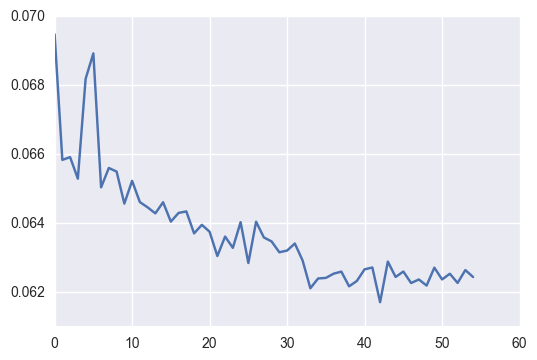

In [19]:
plt.plot(all_results['val_main_output_loss'][10])

In [46]:

mod = load_model(all_results['hdf5'][6])

In [47]:
[(i, l.name, [K.eval(w).shape for w in l.trainable_weights]) for i, l in enumerate(mod.layers)]

[(0, 'value_input', []),
 (1, 'conv1', [(3, 1, 8, 16), (16,)]),
 (2, 'batchnormalization_11', [(16,), (16,)]),
 (3, 'activation_11', []),
 (4, 'conv2', [(3, 1, 16, 16), (16,)]),
 (5, 'batchnormalization_12', [(16,), (16,)]),
 (6, 'activation_12', []),
 (7, 'maxpooling1d_1', []),
 (8, 'conv4', [(3, 1, 16, 16), (16,)]),
 (9, 'batchnormalization_13', [(16,), (16,)]),
 (10, 'activation_13', []),
 (11, 'conv5', [(3, 1, 16, 16), (16,)]),
 (12, 'batchnormalization_14', [(16,), (16,)]),
 (13, 'activation_14', []),
 (14, 'maxpooling1d_2', []),
 (15, 'conv7', [(3, 1, 16, 16), (16,)]),
 (16, 'batchnormalization_15', [(16,), (16,)]),
 (17, 'activation_15', []),
 (18, 'conv8', [(3, 1, 16, 16), (16,)]),
 (19, 'batchnormalization_16', [(16,), (16,)]),
 (20, 'activation_16', []),
 (21, 'maxpooling1d_3', []),
 (22, 'conv10', [(3, 1, 16, 1), (1,)]),
 (23, 'batchnormalization_17', [(1,), (1,)]),
 (24, 'activation_17', []),
 (25, 'flatten_2', []),
 (26, 'dense_2', [(7, 1), (1,)])]

In [6]:
df =pd.DataFrame(np.arange(6).reshape(3,2), columns = ['a', 'b'])

In [8]:
df

,a,b
0,0,1
1,2,3
2,4,5


In [7]:
df.diff()

,a,b
0,NaN,NaN
1,2.0,2.0
2,2.0,2.0


In [2]:
setting = dict(
    objective = 'regr',
)

df0, pivot = get_pivot(setting, all_results, ['aux_weight'])
pivot

NameError: name 'get_pivot' is not defined

(0, 1.5)

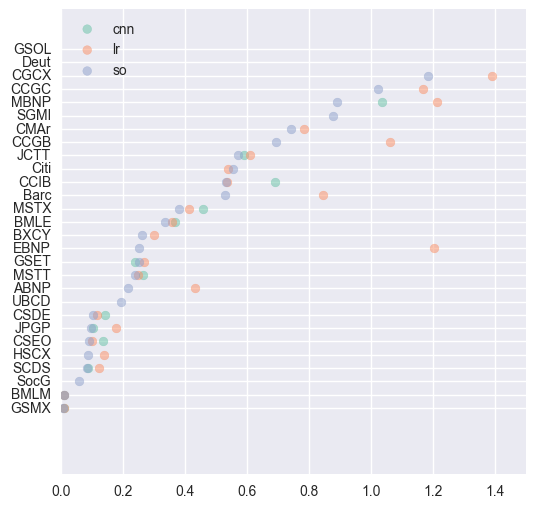

In [5]:
pivot0 = pivot[[c for c in pivot.columns if (len(c) <= 3)]]
# pivot0 = pivot0[np.isnan(pivot0).sum(axis=1)==0].copy()
pivot0 = pivot0.copy()
pivot0.sort_values(pivot0.columns[-1], inplace=True, ascending=True)
pivot0.reset_index(drop=False, inplace=True)
fig, ax = plt.subplots(1, figsize=(6,6))
colors = sns.color_palette("Set2", 8)
for c, color in zip(pivot0.columns[1:], colors):
    ax.scatter(pivot0[c], pivot0.index, label=c, color=color, s=40, alpha=.5)
# ax.set_xscale('log')
ax.set_yticks(pivot0.index)
ax.set_yticklabels(pivot0['data'])
ax.legend(loc=2)
ax.set_xlim((0, 1.5))

In [6]:
df1 = df0[df0['model'] == 'so'].copy()
df1 = df1[df1['best_mse'] == df1.groupby('data')['best_mse'].transform(min)]

In [23]:
from raw_quote import utils, ret_utils, utils2
from keras.models import load_model

sources = ['ABNP', 'BMLE', 'BMLM', 'BXCY','Barc','CCGB','CCGC','CCIB','CGCX','CMAr','CSDE','CSEO','Citi','Deut',
           'EBNP','GSET','GSMX','GSOL','HSCX','JCTT','JPGP','MBNP','MSTT','MSTX','SCDS','SGMI','SocG','UBCD']
cols = sources + ['dir', 'price', 'time'] + ['imps', 'shifts']

def get_layer_no(nn, name):
    for n, l in enumerate(nn.layers):
        if l.name == name:
            print(('layer no for ', l.name, name, n))
            return n
    return None

def get_info(source_id, df, sources=sources, cols=cols, steps=None):
    with tf.Session() as sess:
        nn = load_model(df['hdf5'][source_id])
        source = df.loc[source_id, 'data']

        X, y, n_train, n_all, div, Xmeans, Xstds = utils2.getXy2('preprocessed/raw_%s.pickle' % source, return_stats=True)  
        df.loc[source_id, 'dim'] = X.shape[0]
        if steps is None:
            steps = n_train

        imp = Model(input=[nn.layers[get_layer_no(nn, 'importance_input')].input], 
                    output=[nn.layers[get_layer_no(nn, 'softmax')].output]) # softmax
        shift_input = 'shift_input'
        shift_no = get_layer_no(nn, 'shift_input')
        if shift_no is None:
            shift_no = get_layer_no(nn, 'importance_input')
            shift_input = 'importance_input'
        shift = Model(input=[nn.layers[shift_no].input], 
                      output=[nn.layers[get_layer_no(nn, 'shiftreshape')].output]) #shiftreshape
        length = 100
        gen = utils2.vgen(X, y, 0, n_train, length, utils2.VI_ret_regr, validator=utils2.validator0)

        imps = []
        shifts = []
        info = []
        for i in range(steps):
            if np.random.rand() > .1:
                continue
            xx, _ = next(gen)
            info.append(xx['importance_input'][:, :, :])
            imps.append(imp.predict_on_batch(xx['importance_input']))
            shifts.append(shift.predict_on_batch(xx[shift_input]))
            if i%5000 == 0:
                print('steps %d/%d' % (i, steps))
        
        dim = info[0].shape[0]
        
        info2 = [np.concatenate([inf, i.reshape(dim, 100, 1), sh.reshape(dim, 100, 1)], axis=2) for inf, i, sh in zip(info, imps, shifts)]
        info2 = np.concatenate(np.concatenate(info2, axis=1), axis=0)
        info2[:, :28] = (info2[:, :28] > 0)

        info3 = pd.DataFrame(info2, columns=cols)
        info3['source'] = np.nan
        for s in sources:
            info3.loc[info3[s] > 0, 'source'] = s    
        return info3

In [24]:
df1['dim'] = np.nan
df1['avg_imp'] = np.nan
for idx in df1.index:
    try:
        info = get_info(idx, df1)
        print(df1['data'][idx])
        high_imp = info.groupby('source')['imps'].mean().sort_values(ascending=False)
        df1.loc[idx, 'avg_imp'] = [high_imp.to_dict()]
    except Exception as e:
        print(e)

((64, 26250, 35), 21000, 26250)
('layer no for ', 'importance_input', 'importance_input', 2)
('layer no for ', 'softmax', 'softmax', 33)
('layer no for ', 'shift_input', 'shift_input', 0)
('layer no for ', 'shiftreshape', 'shiftreshape', 29)
BMLM
((64, 26250, 35), 21000, 26250)
('layer no for ', 'importance_input', 'importance_input', 2)
('layer no for ', 'softmax', 'softmax', 33)
('layer no for ', 'shift_input', 'shift_input', 0)
('layer no for ', 'shiftreshape', 'shiftreshape', 29)
GSET
((64, 26250, 35), 21000, 26250)
('layer no for ', 'importance_input', 'importance_input', 2)
('layer no for ', 'softmax', 'softmax', 33)
('layer no for ', 'shift_input', 'shift_input', 0)
('layer no for ', 'shiftreshape', 'shiftreshape', 29)
SCDS
((64, 26250, 35), 21000, 26250)
('layer no for ', 'importance_input', 'importance_input', 8)
('layer no for ', 'softmax', 'softmax', 27)
('layer no for ', 'shift_input', 'shift_input', 0)
('layer no for ', 'shiftreshape', 'shiftreshape', 23)
BMLE
((40, 26250,

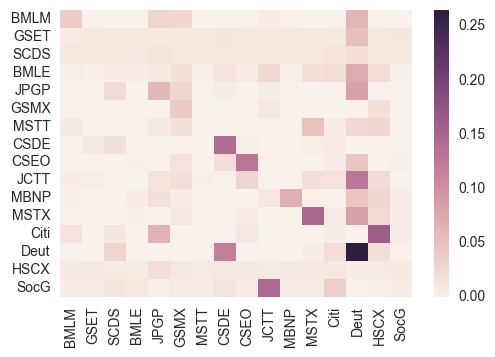

In [26]:
cross_imp = pd.DataFrame([dict(list(y[0].items()) + [('data', x)]) for x, y in zip(df1['data'], df1['avg_imp'])])
cross_imp.set_index('data', drop=True, inplace=True)
# sources_to_plot = [x for x in list(cross_imp.index) if x not in ['CCIB', 'EBNP']]
# sources_to_plot = [s for s in sources if s not in ['ABNP', 'Barc', 'CCGC', 'CCIB', 'CMAr', 'EBNP', 'BXCY', 'GSOL']]
sources_to_plot = ['BMLM', 'GSET', 'SCDS', 'BMLE', 'JPGP', 'GSMX', 'MSTT', 'CSDE', 'CSEO', 
                   'JCTT', 'MBNP', 'MSTX', 'Citi', 'Deut', 'HSCX', 'SocG']
fig, ax = plt.subplots(1, figsize=(5,3.5))
sns.heatmap(cross_imp.loc[sources_to_plot, sources_to_plot], ax=ax)
ax.set_ylabel('')
# ax.invert_yaxis()
fig.subplots_adjust(bottom=0.15, left=.11, top=.97, right=.99)
fig.savefig('plots\cross_significance2.png')

In [327]:
pd.DataFrame([dict(list(y[0].items()) + [('data', x)]) for x, y in zip(df1['data'], df1['avg_imp'])])

KeyError: 'avg_imp'

In [65]:
df1['file']

461             keras__regr_ret.pkl
465             keras__regr_ret.pkl
472             keras__regr_ret.pkl
473             keras__regr_ret.pkl
476             keras__regr_ret.pkl
482             keras__regr_ret.pkl
494             keras__regr_ret.pkl
498             keras__regr_ret.pkl
530          keras__regr_ret_fs.pkl
533          keras__regr_ret_fs.pkl
534          keras__regr_ret_fs.pkl
537          keras__regr_ret_fs.pkl
539          keras__regr_ret_fs.pkl
541          keras__regr_ret_fs.pkl
547    keras__regr_ret_fs_part2.pkl
548    keras__regr_ret_fs_part2.pkl
549    keras__regr_ret_fs_part2.pkl
550    keras__regr_ret_fs_part2.pkl
551    keras__regr_ret_fs_part2.pkl
552    keras__regr_ret_fs_part2.pkl
553    keras__regr_ret_fs_part2.pkl
554    keras__regr_ret_fs_part2.pkl
555    keras__regr_ret_fs_part2.pkl
556    keras__regr_ret_fs_part2.pkl
557    keras__regr_ret_fs_part2.pkl
558    keras__regr_ret_fs_part2.pkl
559    keras__regr_ret_fs_part2.pkl
560    keras__regr_ret_fs_pa

In [17]:
print(list(df1['data'][df1['dim'] > 30]))

['BMLM', 'GSET', 'SCDS', 'BMLE', 'CCIB', 'JPGP', 'GSMX', 'MSTT', 'CSDE', 'CSEO', 'EBNP', 'JCTT', 'MBNP', 'MSTX', 'Barc', 'Citi', 'Deut', 'HSCX', 'SocG']


In [19]:
df1[['data', 'dim']]

,data,dim
471,BMLM,64.0
475,GSET,64.0
482,SCDS,64.0
483,BMLE,64.0
486,CCIB,40.0
492,JPGP,64.0
504,GSMX,64.0
508,MSTT,64.0
540,CSDE,64.0
543,CSEO,64.0
